In [35]:
nmax = 2000
nmin = -2000

In [36]:
data = load(f"HV_curves/({nmin},{nmax})_average_aps")

In [37]:
phi_reps = data['phi_reps']
cs = data['conductors']

In [38]:
len(phi_reps)

1317

Power law fit: A=5.69e-04, α=0.393
Saved fit parameters to HV_curves/(-2000,2000)_powerlaw_fit_params.sobj
Saved plot: HV_curves/(-2000,2000)_conductor_distribution_fit.png


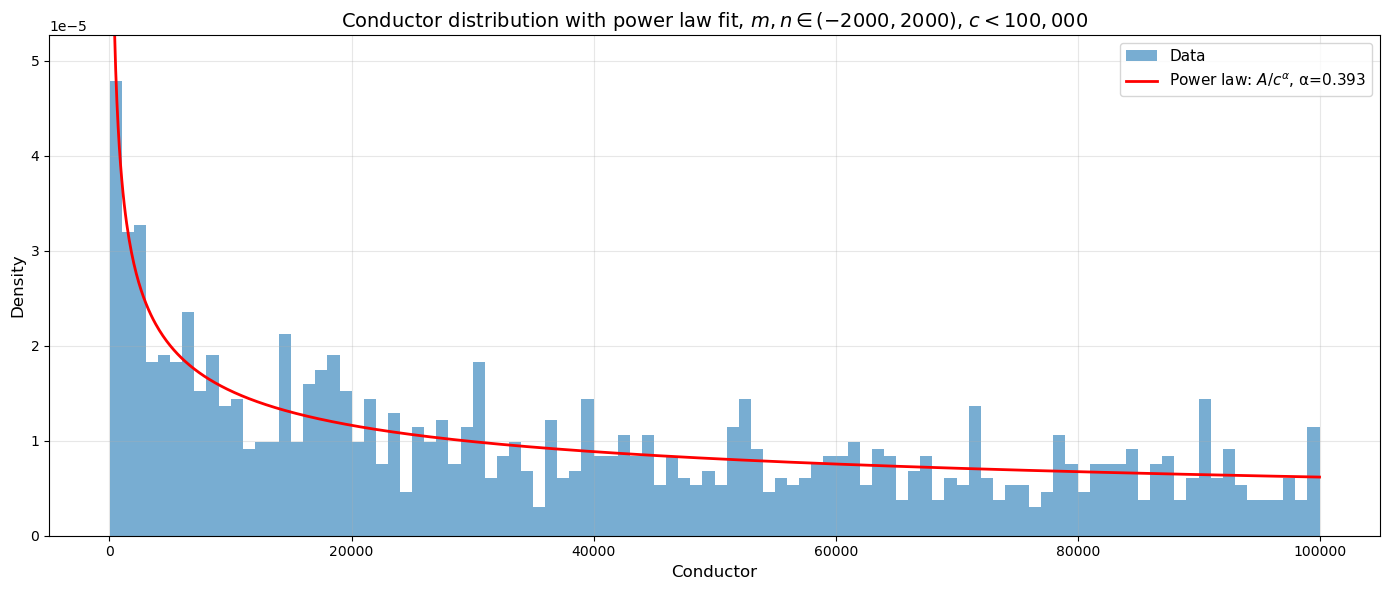

Saved plot: HV_curves/(-2000,2000)_conductor_distribution_loglog.png


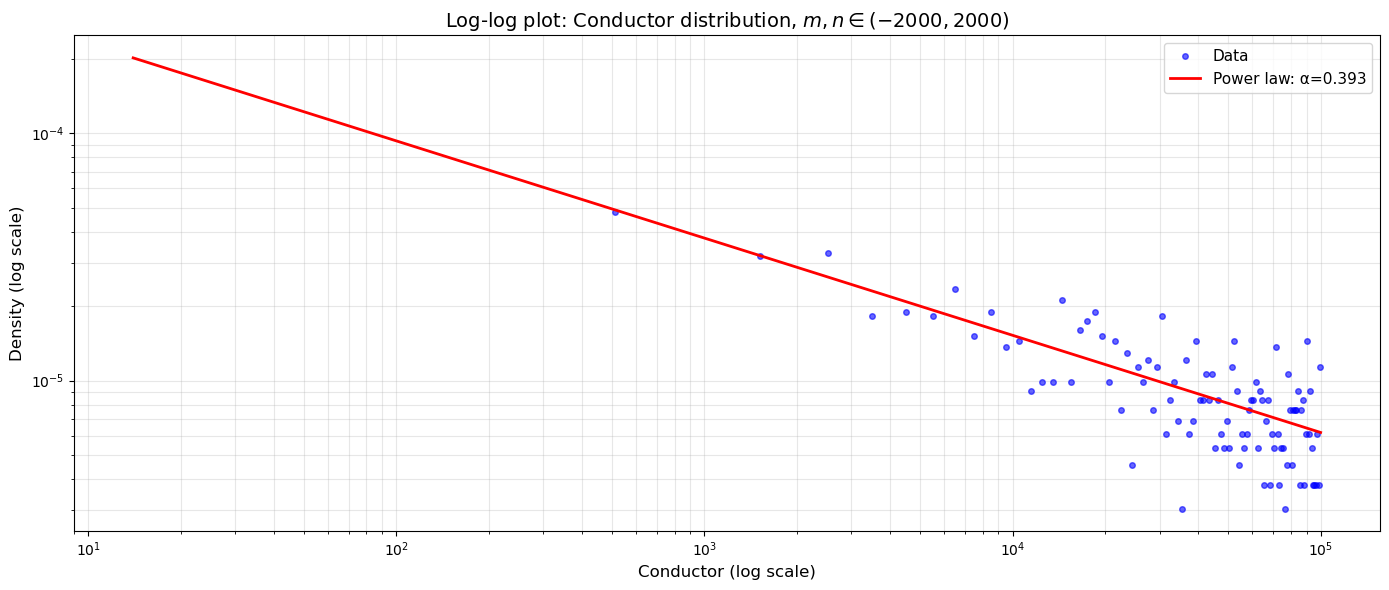

In [39]:
# Plot distribution of conductors with power law fit
from scipy.optimize import curve_fit
import numpy as np

# Define power law function
def power_law(x, A, alpha):
    """Power law: A / x^alpha"""
    return A / (x**alpha)

plt.figure(figsize=(14, 6))

# Create histogram
counts, bins, patches = plt.hist(cs, bins=100, density=True, alpha=0.6, label='Data')

# Fit power law 1/x^alpha
# Use bin centers for fitting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter out zero counts for better fitting
mask = counts > 0

try:
    popt, pcov = curve_fit(power_law, bin_centers[mask], counts[mask], p0=[1e6, 1.5], maxfev=10000)
    A_fit, alpha_fit = popt
    
    x_fit = np.linspace(min(cs), max(cs), 1000)
    y_power = power_law(x_fit, A_fit, alpha_fit)
    
    plt.plot(x_fit, y_power, 'r-', linewidth=2, label=f'Power law: $A/c^{{\\alpha}}$, α={alpha_fit:.3f}')
    print(f"Power law fit: A={A_fit:.2e}, α={alpha_fit:.3f}")
    
    # Save fit parameters
    fit_params = {
        'A': A_fit,
        'alpha': alpha_fit,
        'c_min': min(cs),
        'c_max': max(cs)
    }
    save(fit_params, f'HV_curves/({nmin},{nmax})_powerlaw_fit_params.sobj')
    print(f"Saved fit parameters to HV_curves/({nmin},{nmax})_powerlaw_fit_params.sobj")
    
except Exception as e:
    print(f"Power law fit failed: {e}")

# Set y-axis limits based on histogram data, not the fit
plt.ylim(0, np.max(counts) * 1.1)  # 10% margin above max histogram value

plt.xlabel("Conductor", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title(fr"Conductor distribution with power law fit, $m,n\in({nmin},{nmax})$, $c<100,000$", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'HV_curves/({nmin},{nmax})_conductor_distribution_fit.png', dpi=150)
print(f"Saved plot: HV_curves/({nmin},{nmax})_conductor_distribution_fit.png")
plt.show()
plt.close()

# Also create a log-log plot to visualize power law behavior
plt.figure(figsize=(14, 6))

counts_nonzero = counts[counts > 0]
bin_centers_nonzero = bin_centers[counts > 0]

plt.loglog(bin_centers_nonzero, counts_nonzero, 'bo', alpha=0.6, label='Data', markersize=4)

# Plot fitted power law on log-log scale
try:
    x_fit_positive = x_fit[x_fit > 0]
    y_power_fit = power_law(x_fit_positive, A_fit, alpha_fit)
    plt.loglog(x_fit_positive, y_power_fit, 'r-', linewidth=2, 
               label=f'Power law: α={alpha_fit:.3f}')
except:
    pass

plt.xlabel("Conductor (log scale)", fontsize=12)
plt.ylabel("Density (log scale)", fontsize=12)
plt.title(fr"Log-log plot: Conductor distribution, $m,n\in({nmin},{nmax})$", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.savefig(f'HV_curves/({nmin},{nmax})_conductor_distribution_loglog.png', dpi=150)
print(f"Saved plot: HV_curves/({nmin},{nmax})_conductor_distribution_loglog.png")
plt.show()
plt.close()

Saved plot: HV_curves/alpha_conductor_fit.png


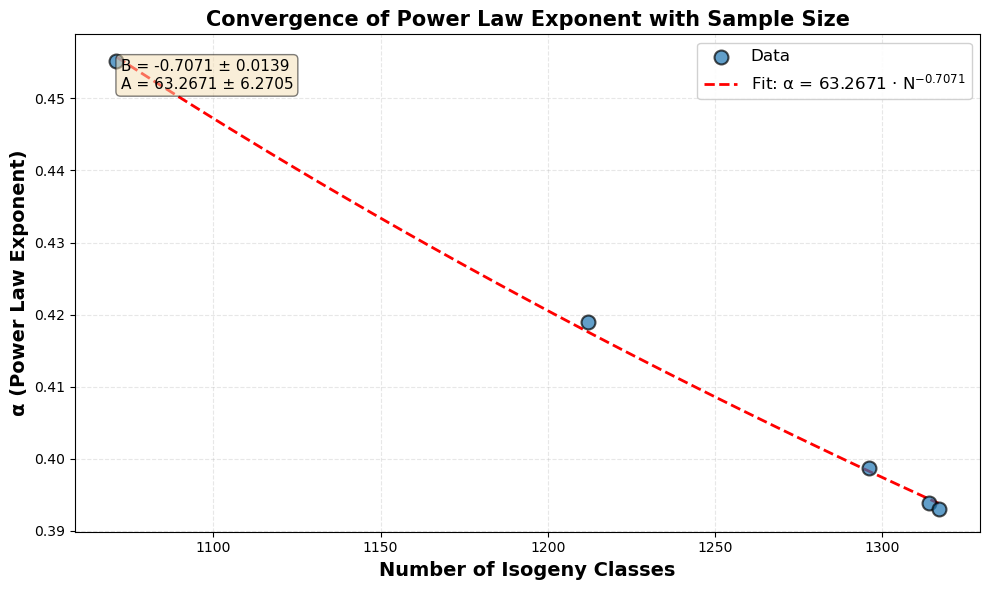

In [34]:
import numpy as np
from scipy.optimize import curve_fit

# Plot alphas vs number of isogeny classes in each run of fraction sampling
isos = []
alphas = []
maxes = [100, 200, 500, 1000, 2000]
for m in maxes:
    nmin = -m
    nmax = m
    params = load(f"HV_curves/({nmin},{nmax})_powerlaw_fit_params")
    data = load(f"HV_curves/({nmin},{nmax})_average_aps")
    phi_reps = data['phi_reps']
    
    isos.append(len(phi_reps))
    alphas.append(params['alpha'])

# Convert to numpy arrays for fitting
isos_arr = np.array(isos)
alphas_arr = np.array(alphas)

# Powerlaw fit: alpha = A * isos^B
def powerlaw(x, A, B):
    return A * x**B

# Fit the data
popt, pcov = curve_fit(powerlaw, isos_arr, alphas_arr)
A_fit, B_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard errors

# Generate smooth curve for plotting
isos_smooth = np.linspace(min(isos_arr), max(isos_arr), 100)
alphas_fit = powerlaw(isos_smooth, A_fit, B_fit)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(isos, alphas, s=100, alpha=0.7, edgecolors='black', linewidth=1.5, 
            label='Data', zorder=3)
plt.plot(isos_smooth, alphas_fit, 'r--', linewidth=2, 
         label=f'Fit: α = {A_fit:.4f} · N$^{{{B_fit:.4f}}}$', zorder=2)

# Styling
plt.xlabel('Number of Isogeny Classes', fontsize=14, fontweight='bold')
plt.ylabel('α (Power Law Exponent)', fontsize=14, fontweight='bold')
plt.title('Convergence of Power Law Exponent with Sample Size', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=12, framealpha=0.9)
plt.tight_layout()

# Add text box with fit statistics
textstr = f'B = {B_fit:.4f} ± {perr[1]:.4f}\nA = {A_fit:.4f} ± {perr[0]:.4f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig(f'HV_curves/alpha_conductor_fit.png', dpi=150)
print(f"Saved plot: HV_curves/alpha_conductor_fit.png")
plt.show()

Student-t normalized fit: x0=-0.530, sigma=2.617, nu=100.000
Saved fit parameters: HV_curves/(-500,500)_phi_dist_tfit_params.txt
Saved plot: HV_curves/(-500,500)_phi_dist_tfit.png


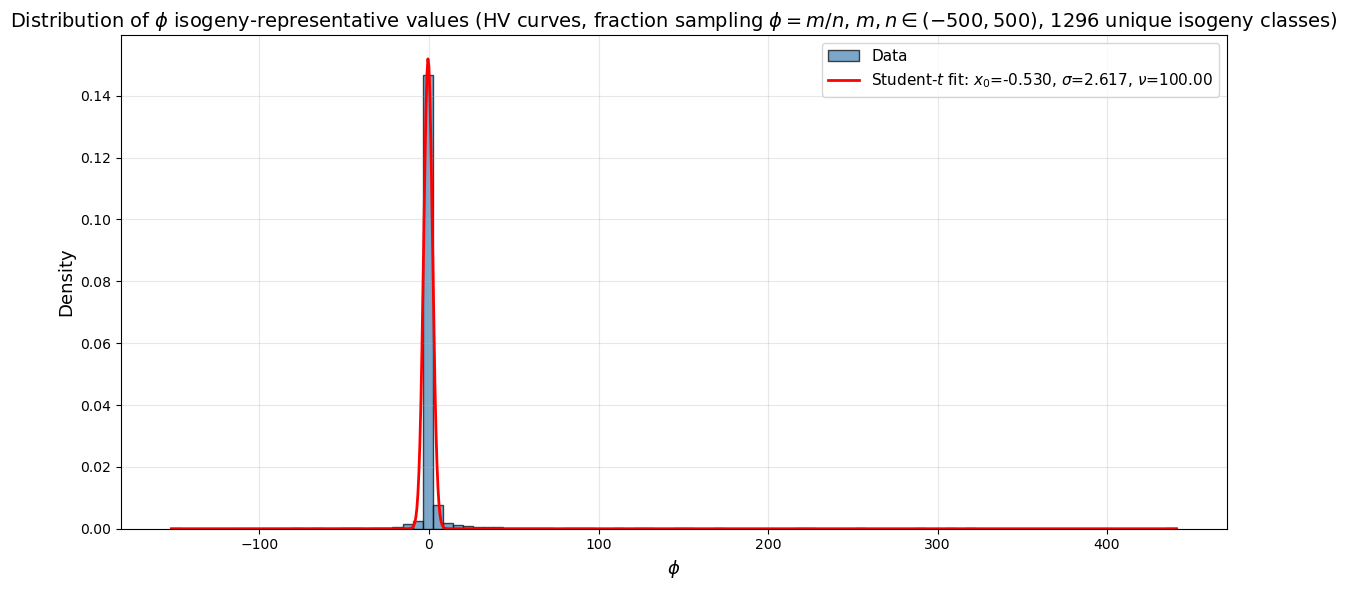

In [40]:
# Fit phi distribution - fraction sampling
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma

# Load dataset 
nmax = 500
nmin = -500
data = load(f"HV_curves/({nmin},{nmax})_average_aps")
phi_reps = data['phi_reps']

# Convert to float
phi_reps_float = [float(x) for x in phi_reps]

plt.figure(figsize=(12, 6))

# Create normalized histogram
counts, bins, _ = plt.hist(
    phi_reps_float, bins=100, density=True,
    edgecolor='black', alpha=0.7, color='steelblue',
    label='Data'
)

# ---------- Normalized Student's t distribution ----------
def student_t_norm(x, x0, sigma, nu):
    """Normalized symmetric Student-t PDF."""
    norm = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * sigma * gamma(nu / 2))
    return norm * (1 + ((x - x0)**2) / (nu * sigma**2)) ** (-(nu + 1) / 2)

# Compute bin centers for fitting
bin_centers = 0.5 * (bins[:-1] + bins[1:])
mask = counts > 0

# Initial guesses
x0_guess = np.mean(phi_reps_float)
sigma_guess = np.std(phi_reps_float)
nu_guess = 2.0  # moderate tails

try:
    popt, pcov = curve_fit(
        student_t_norm,
        bin_centers[mask],
        counts[mask],
        p0=[x0_guess, sigma_guess, nu_guess],
        bounds=([-np.inf, 1e-6, 0.1], [np.inf, np.inf, 100]),
        maxfev=20000
    )
    x0_fit, sigma_fit, nu_fit = popt
    
    # Generate fitted curve
    x_fit = np.linspace(min(phi_reps_float), max(phi_reps_float), 1000)
    y_fit = student_t_norm(x_fit, x0_fit, sigma_fit, nu_fit)
    
    # Plot fit with parameters in legend
    plt.plot(
        x_fit, y_fit, 'r-', linewidth=2,
        label=(
            r"Student-$t$ fit: "
            fr"$x_0$={x0_fit:.3f}, $\sigma$={sigma_fit:.3f}, $\nu$={nu_fit:.2f}"
        )
    )
    
    print(f"Student-t normalized fit: x0={x0_fit:.3f}, sigma={sigma_fit:.3f}, nu={nu_fit:.3f}")
    
    # Save fit parameters
    params_path = f'HV_curves/({nmin},{nmax})_phi_dist_tfit_params.txt'
    with open(params_path, 'w') as f:
        f.write("Student-t normalized fit parameters\n")
        f.write(f"Fraction sampling: phi = m/n with m, n in ({nmin}, {nmax})\n")
        f.write(f"x0 = {x0_fit:.6f}\n")
        f.write(f"sigma = {sigma_fit:.6f}\n")
        f.write(f"nu = {nu_fit:.6f}\n")
    print(f"Saved fit parameters: {params_path}")
    
except Exception as e:
    print(f"Student-t fit failed: {e}")

# Labels and title
plt.xlabel(r'$\phi$', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title(
    fr'Distribution of $\phi$ isogeny-representative values '
    fr'(HV curves, fraction sampling $\phi = m/n$, '
    fr'$m, n \in ({nmin}, {nmax})$, {len(phi_reps)} unique isogeny classes)',
    fontsize=14
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
save_path = f'HV_curves/({nmin},{nmax})_phi_dist_tfit.png'
plt.savefig(save_path, dpi=150)
print(f"Saved plot: {save_path}")

plt.show()

In [34]:
m = 1000
nmin = -m
nmax = m
phi_data = load(f"phi_scan_results/({nmin},{nmax})_phi_scan_data")

In [36]:
phi_data['total_phis_generated']

1216767

Saved plot: phi_scan_results/nisos_vs_nphis_satexp_fit.png
Saved fit parameters: phi_scan_results/nisos_vs_nphis_satexp_params.txt


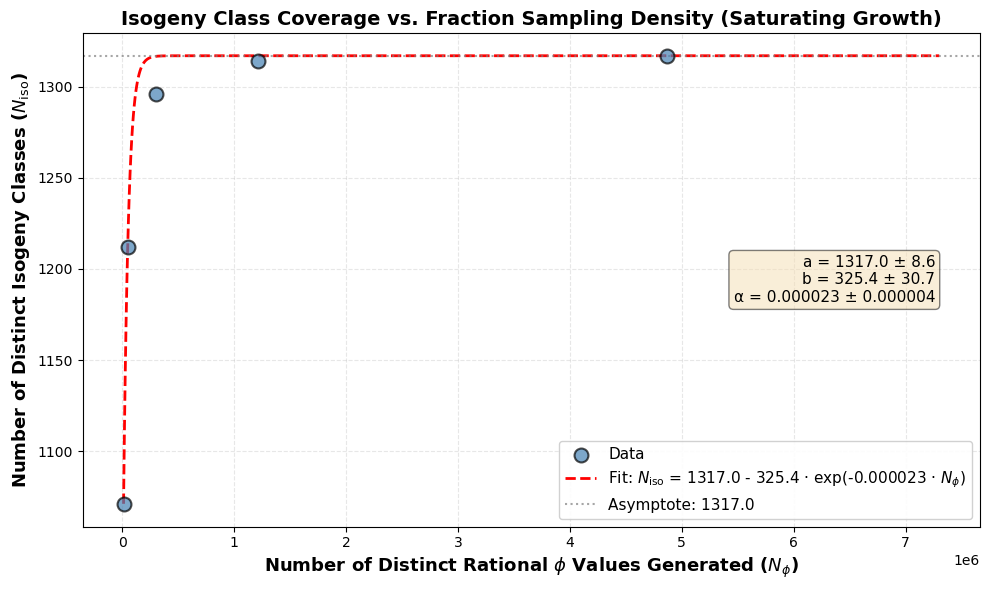


Saturating exponential fit: N_iso = 1317.0 - 325.4 * exp(-0.000023 * N_phi)
Parameters: a (asymptote) = 1317.0 ± 8.6
            b = 325.4 ± 30.7
            α = 0.000023 ± 0.000004

Interpretation: Approaching ~1317 total isogeny classes


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# Plot number of phis associated to distinct isogeny classes vs number of distinct rationals phis generated
nisos = []
nphis = []
maxes = [100, 200, 500, 1000, 2000]
for m in maxes:
    nmin = -m
    nmax = m
    phi_data = load(f"phi_scan_results/({nmin},{nmax})_phi_scan_data")
    
    nisos.append(len(phi_data['isogeny_classes']))
    nphis.append(phi_data['total_phis_generated'])
# Convert to numpy arrays for fitting
nphis_arr = np.array(nphis)
nisos_arr = np.array(nisos)
# Saturating exponential fit: nisos = a - b * exp(-alpha * x)
def satexp_fit(x, a, b, alpha):
    return a - b * np.exp(-alpha * x)
# Initial guesses
a_guess = max(nisos_arr) * 1.5  # Asymptote above current max
b_guess = a_guess - min(nisos_arr)  # So that at x=0, y ≈ min
alpha_guess = 0.001  # Slow approach to asymptote
# Fit the data with bounds to ensure correct behavior
popt, pcov = curve_fit(satexp_fit, nphis_arr, nisos_arr,
                       p0=[a_guess, b_guess, alpha_guess],
                       bounds=([max(nisos_arr), 0, 0], [np.inf, np.inf, 1]),
                       maxfev=20000)
a_fit, b_fit, alpha_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard errors
# Generate smooth curve for plotting
nphis_smooth = np.linspace(min(nphis_arr), max(nphis_arr) * 1.5, 1000)
nisos_fit = satexp_fit(nphis_smooth, a_fit, b_fit, alpha_fit)
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(nphis, nisos, s=100, alpha=0.7, edgecolors='black', linewidth=1.5, 
            label='Data', zorder=3, color='steelblue')
plt.plot(nphis_smooth, nisos_fit, 'r--', linewidth=2, 
         label=f'Fit: $N_{{\\rm iso}}$ = {a_fit:.1f} - {b_fit:.1f} · exp(-{alpha_fit:.6f} · $N_\\phi$)', zorder=2)
# Add horizontal line for asymptote
plt.axhline(y=a_fit, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'Asymptote: {a_fit:.1f}')
# Styling
plt.xlabel('Number of Distinct Rational $\\phi$ Values Generated ($N_\\phi$)', 
           fontsize=13, fontweight='bold')
plt.ylabel('Number of Distinct Isogeny Classes ($N_{\\rm iso}$)', 
           fontsize=13, fontweight='bold')
plt.title('Isogeny Class Coverage vs. Fraction Sampling Density (Saturating Growth)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, framealpha=0.9, loc='lower right')
plt.tight_layout()
# Add text box with fit statistics - MIDDLE RIGHT
textstr = f'a = {a_fit:.1f} ± {perr[0]:.1f}\nb = {b_fit:.1f} ± {perr[1]:.1f}\nα = {alpha_fit:.6f} ± {perr[2]:.6f}'
plt.text(0.95, 0.50, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# Save plot
save_path = 'phi_scan_results/nisos_vs_nphis_satexp_fit.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved plot: {save_path}")
# Save fit parameters
params_path = 'phi_scan_results/nisos_vs_nphis_satexp_params.txt'
with open(params_path, 'w') as f:
    f.write("Saturating exponential fit: N_iso = a - b * exp(-alpha * N_phi)\n")
    f.write("="*50 + "\n")
    f.write(f"a (asymptote) = {a_fit:.8f} ± {perr[0]:.8f}\n")
    f.write(f"b             = {b_fit:.8f} ± {perr[1]:.8f}\n")
    f.write(f"alpha         = {alpha_fit:.10f} ± {perr[2]:.10f}\n")
    f.write(f"\nAsymptotic limit: {a_fit:.1f} isogeny classes\n")
    f.write(f"At N_phi=0: N_iso = {a_fit - b_fit:.1f}\n")
    f.write("\n")
    f.write("Data points:\n")
    for i, m in enumerate(maxes):
        predicted = satexp_fit(nphis[i], a_fit, b_fit, alpha_fit)
        residual = nisos[i] - predicted
        percent_of_asymptote = (nisos[i] / a_fit) * 100
        f.write(f"  m={m:4d}: N_phi={nphis[i]:6d}, N_iso={nisos[i]:5d}, "
                f"predicted={predicted:.1f}, residual={residual:.1f}, "
                f"({percent_of_asymptote:.1f}% of asymptote)\n")
print(f"Saved fit parameters: {params_path}")
plt.show()
# Print summary
print(f"\nSaturating exponential fit: N_iso = {a_fit:.1f} - {b_fit:.1f} * exp(-{alpha_fit:.6f} * N_phi)")
print(f"Parameters: a (asymptote) = {a_fit:.1f} ± {perr[0]:.1f}")
print(f"            b = {b_fit:.1f} ± {perr[1]:.1f}")
print(f"            α = {alpha_fit:.6f} ± {perr[2]:.6f}")
print(f"\nInterpretation: Approaching ~{a_fit:.0f} total isogeny classes")

In [1]:
# Restrict conductor range on HV classes set

m = 2000
nmin = -m
nmax = m

data = load(f"HV_curves/({nmin},{nmax})_average_aps")

In [2]:
isos = data['isogeny_classes']

In [3]:
curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')

In [4]:
cs = []

for label in list(curve_db.keys()):
    cs.append(curve_db[label]['conductor'])

Saved plot: Database_pictures/conductor_distribution_c100k_density.png
Fit parameters: a = 1.01483271e-05, b = 4.58510455e-06, alpha = 0.00030939
Saved fit parameters: Database_pictures/conductor_fit_parameters_density.txt


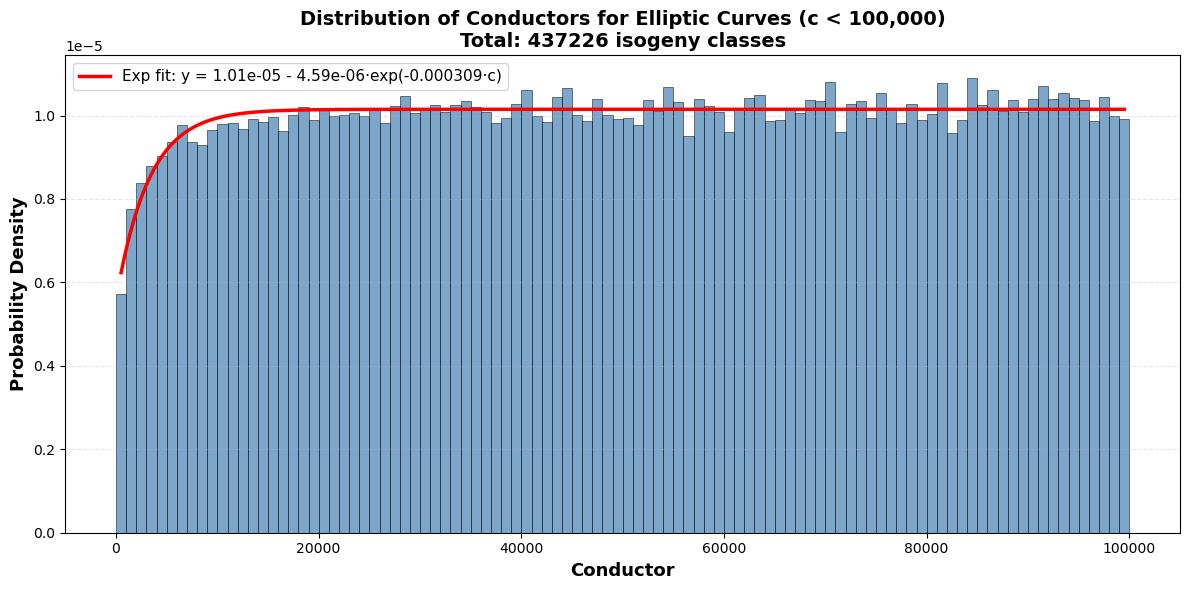

In [8]:
# Plot the distribution of conductors for all isogeny classes with conductor less than 100,000
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

plt.figure(figsize=(12, 6))

# Create histogram with density normalization
counts, bins, patches = plt.hist(cs, bins=100, edgecolor='black', alpha=0.7, 
                                  color='steelblue', linewidth=0.5, density=True)

# Prepare data for exponential fit
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define exponential function: y = a - b*exp(-alpha*x)
def exp_func(x, a, b, alpha):
    return a - b * np.exp(-alpha * x)

# Fit the exponential function with initial guesses
p0 = [np.max(counts), np.max(counts), 0.0001]  # Initial guesses
popt, pcov = curve_fit(exp_func, bin_centers, counts, p0=p0, maxfev=10000)
a, b, alpha = popt

# Generate smooth curve for plotting
x_fit = np.linspace(bin_centers[0], bin_centers[-1], 1000)
y_fit = exp_func(x_fit, a, b, alpha)

# Plot the fit
plt.plot(x_fit, y_fit, 'r-', linewidth=2.5, 
         label=f'Exp fit: y = {a:.2e} - {b:.2e}·exp(-{alpha:.6f}·c)')

# Styling
plt.xlabel('Conductor', fontsize=13, fontweight='bold')
plt.ylabel('Probability Density', fontsize=13, fontweight='bold')
plt.title(f'Distribution of Conductors for Elliptic Curves (c < 100,000)\n'
          f'Total: {len(cs)} isogeny classes', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()

# Save plot
save_path = 'Database_pictures/conductor_distribution_c100k_density.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved plot: {save_path}")
print(f"Fit parameters: a = {a:.8e}, b = {b:.8e}, alpha = {alpha:.8f}")

# Save fit parameters to file
params_path = 'Database_pictures/conductor_fit_parameters_density.txt'
with open(params_path, 'w') as f:
    f.write(f"Exponential fit (density): y = a - b*exp(-alpha*c)\n")
    f.write(f"a = {a:.12e}\n")
    f.write(f"b = {b:.12e}\n")
    f.write(f"alpha = {alpha:.12e}\n")
print(f"Saved fit parameters: {params_path}")

plt.show()

Found 1317 isogeny classes in the conductor range (1,100000).
Saved conductor distribution plot to HV_curves_conductor_range/conductor_distribution_1_100000.png


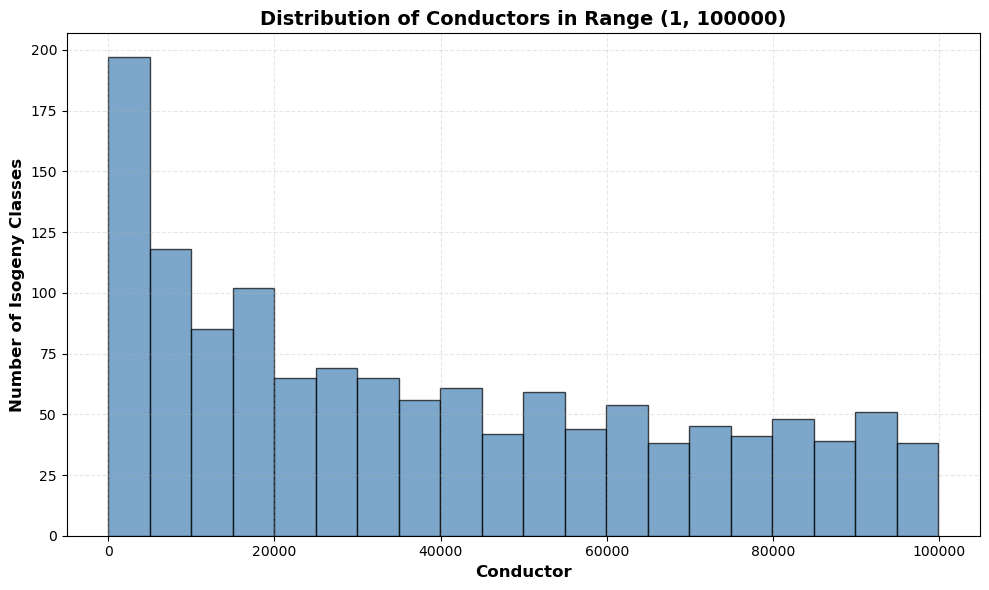

Found 664 rank 0, 624 rank 1, 29 rank 2 isogeny classes.
Saved average ap plot to HV_curves_conductor_range/average_ap_by_rank_1_100000.png


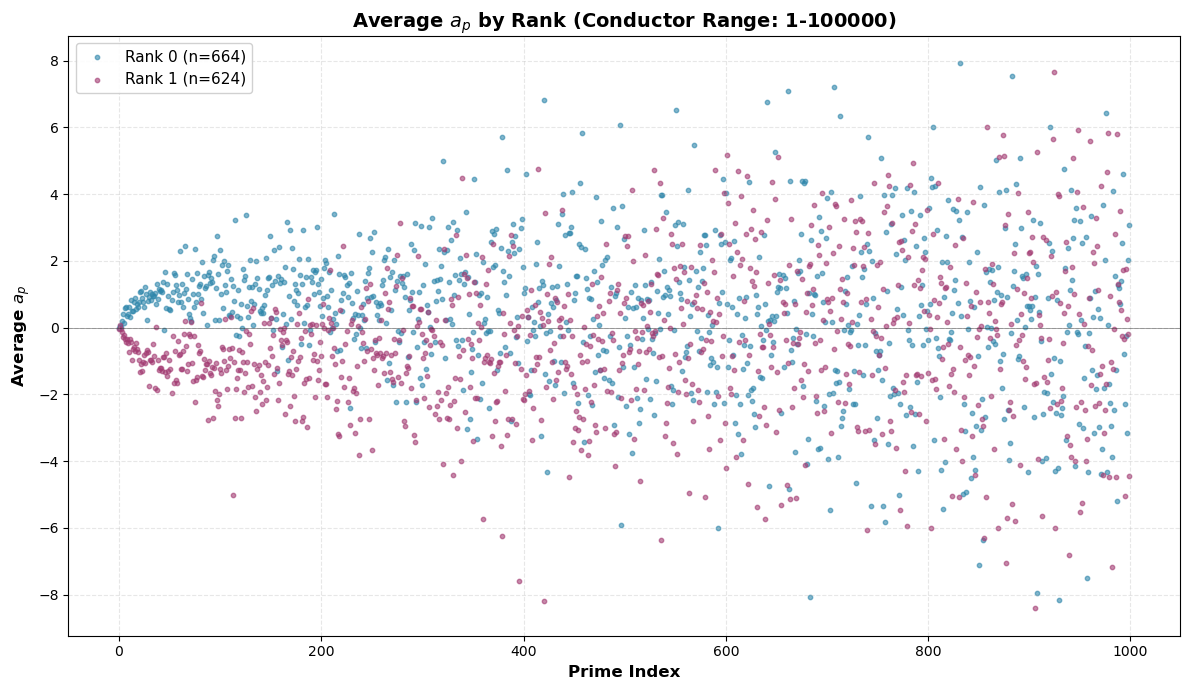


All plots saved to HV_curves_conductor_range/


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Check if curve_db is loaded, if not load it
try:
    curve_db
except NameError:
    print("Loading curve database...")
    curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')
    print("Curve database loaded.")

# Create output directory if it doesn't exist
output_dir = "HV_curves_conductor_range"
os.makedirs(output_dir, exist_ok=True)

# Restrict conductor range on HV classes set
m = 2000
nmin = -m
nmax = m
data = load(f"HV_curves/({nmin},{nmax})_average_aps")
isos = data['isogeny_classes']
cmin = 1
cmax = 100000
cs = []
r_isos = []
for iso in isos:
    curve = curve_db[iso]
    c = curve['conductor']
    if c > cmin and c < cmax:
        cs.append(c)
        r_isos.append(iso)
print(f"Found {len(cs)} isogeny classes in the conductor range ({cmin},{cmax}).")

# Plot distribution of conductors over the chosen range
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(cs, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Conductor', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Isogeny Classes', fontsize=12, fontweight='bold')
ax1.set_title(f'Distribution of Conductors in Range ({cmin}, {cmax})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=10)
plt.tight_layout()
plt.savefig(f"{output_dir}/conductor_distribution_{cmin}_{cmax}.png", dpi=300, bbox_inches='tight')
print(f"Saved conductor distribution plot to {output_dir}/conductor_distribution_{cmin}_{cmax}.png")
plt.show()  # Display the plot

# Separate by rank
r_rk0_aps = []
r_rk1_aps = []
r_rk2_aps = []
for iso in r_isos:
    curve = curve_db[iso]
    r = curve['rank']
    if r == 0:
        r_rk0_aps.append(curve['ap_list'])
    if r == 1:
        r_rk1_aps.append(curve['ap_list'])
    if r == 2:
        r_rk2_aps.append(curve['ap_list'])

r_rk0_aps_average = np.mean(r_rk0_aps, axis=0)
r_rk1_aps_average = np.mean(r_rk1_aps, axis=0)
r_rk2_aps_average = np.mean(r_rk2_aps, axis=0)
print(f"Found {len(r_rk0_aps)} rank 0, {len(r_rk1_aps)} rank 1, {len(r_rk2_aps)} rank 2 isogeny classes.")

# Plot average aps
fig2, ax2 = plt.subplots(figsize=(12, 7))
n_points = len(r_rk0_aps_average)
x = np.arange(n_points)

ax2.scatter(x, r_rk0_aps_average, s=10, alpha=0.6, color='#2E86AB', label=f'Rank 0 (n={len(r_rk0_aps)})')
ax2.scatter(x, r_rk1_aps_average, s=10, alpha=0.6, color='#A23B72', label=f'Rank 1 (n={len(r_rk1_aps)})')
if len(r_rk2_aps) > 100:
    ax2.scatter(x, r_rk2_aps_average, s=10, alpha=0.6, color='#F18F01', label=f'Rank 2 (n={len(r_rk2_aps)})')

ax2.set_xlabel('Prime Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average $a_p$', fontsize=12, fontweight='bold')
ax2.set_title(f'Average $a_p$ by Rank (Conductor Range: {cmin}-{cmax})', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(f"{output_dir}/average_ap_by_rank_{cmin}_{cmax}.png", dpi=300, bbox_inches='tight')
print(f"Saved average ap plot to {output_dir}/average_ap_by_rank_{cmin}_{cmax}.png")
plt.show()  # Display the plot

print(f"\nAll plots saved to {output_dir}/")

Importing aps of curves in conductor range (7500,10000)...


Importing curves: 100%|████████████████████████████████████████████████████| 437226/437226 [00:00<00:00, 1003179.77it/s]


Done.
Found 10293 curves: 4328 rank 0 curves, 5194 rank 1 curves, 771 rank 2 curves
Saved conductor distribution plot to Database_pictures/conductor_distribution_7500_10000.png


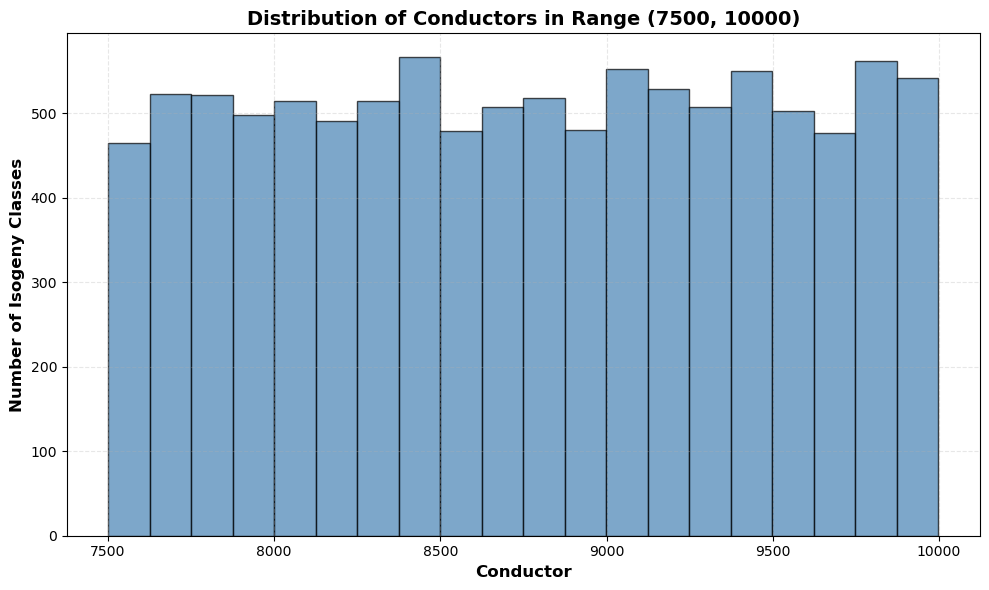

Averaging aps...
Done.
Saved average ap plot to Database_pictures/average_ap_by_rank_7500_10000.png


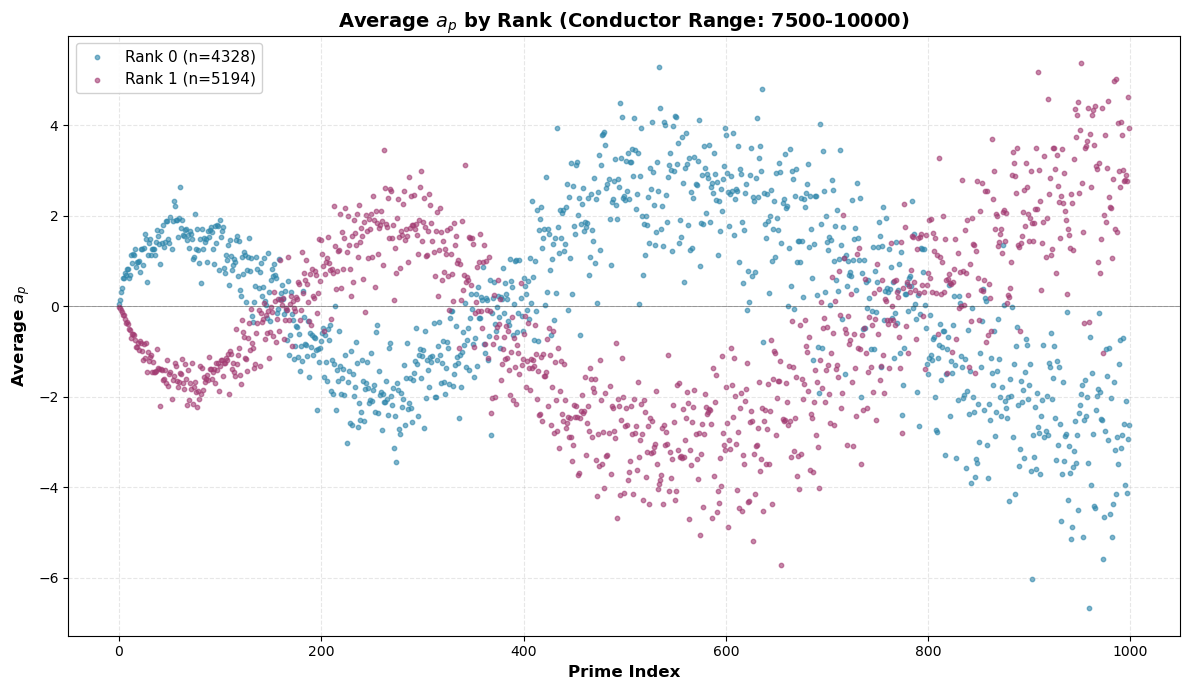


All plots saved to Database_pictures/


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Check if curve_db is loaded, if not load it
try:
    curve_db
except NameError:
    print("Loading curve database...")
    curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')
    print("Curve database loaded.")

# Create output directory if it doesn't exist
output_dir = "Database_pictures"
os.makedirs(output_dir, exist_ok=True)

# Compute average aps over given conductor range
cmin = 7500
cmax = 10000
rk0_aps = []
rk1_aps = []
rk2_aps = []
cs = []
print(f"Importing aps of curves in conductor range ({cmin},{cmax})...")
for iso in tqdm(curve_db.keys(), desc="Importing curves: "):
    curve = curve_db[iso]
    aps = curve['ap_list']
    r = curve['rank']
    c = curve['conductor']
    if c < cmax and c > cmin:
        if r == 0:
            rk0_aps.append(aps)
        if r == 1:
            rk1_aps.append(aps)
        if r == 2:
            rk2_aps.append(aps)
        cs.append(c)
print(f"Done.\nFound {len(rk0_aps)+len(rk1_aps)+len(rk2_aps)} curves: {len(rk0_aps)} rank 0 curves, {len(rk1_aps)} rank 1 curves, {len(rk2_aps)} rank 2 curves")

# Plot distribution of conductors over the chosen range
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(cs, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Conductor', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Isogeny Classes', fontsize=12, fontweight='bold')
ax1.set_title(f'Distribution of Conductors in Range ({cmin}, {cmax})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=10)
plt.tight_layout()
plt.savefig(f"{output_dir}/conductor_distribution_{cmin}_{cmax}.png", dpi=300, bbox_inches='tight')
print(f"Saved conductor distribution plot to {output_dir}/conductor_distribution_{cmin}_{cmax}.png")
plt.show()  # Display the plot

print("Averaging aps...")
rk0_aps_average = np.mean(rk0_aps, axis=0)
rk1_aps_average = np.mean(rk1_aps, axis=0)
rk2_aps_average = np.mean(rk2_aps, axis=0)
print("Done.")

# Plot average aps
fig2, ax2 = plt.subplots(figsize=(12, 7))
n_points = len(rk0_aps_average)
x = np.arange(n_points)

ax2.scatter(x, rk0_aps_average, s=10, alpha=0.6, color='#2E86AB', label=f'Rank 0 (n={len(rk0_aps)})')
ax2.scatter(x, rk1_aps_average, s=10, alpha=0.6, color='#A23B72', label=f'Rank 1 (n={len(rk1_aps)})')
if len(rk2_aps) > 1000:
    ax2.scatter(x, rk2_aps_average, s=10, alpha=0.6, color='#F18F01', label=f'Rank 2 (n={len(rk2_aps)})')

ax2.set_xlabel('Prime Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average $a_p$', fontsize=12, fontweight='bold')
ax2.set_title(f'Average $a_p$ by Rank (Conductor Range: {cmin}-{cmax})', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(f"{output_dir}/average_ap_by_rank_{cmin}_{cmax}.png", dpi=300, bbox_inches='tight')
print(f"Saved average ap plot to {output_dir}/average_ap_by_rank_{cmin}_{cmax}.png")
plt.show()  # Display the plot

print(f"\nAll plots saved to {output_dir}/")